In [1]:
import torch
import torch.nn as nn

In [2]:
# now i can define the blocks that i need ...

class resnetBlock(nn.Module):
    
        def __init__(self, in_channels, out_channels, activation = nn.LeakyReLU()):
            super().__init__()
            self.activation = activation
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3,stride = 1,  padding=1)
            self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride = 1, padding=1)

                    # nn.(8, in_channels if i == 0 else out_channels),
            self.bn1 = nn.BatchNorm2d(in_channels)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.in_channels = in_channels
            self.out_channels = out_channels
            
            self.res_input_conv = nn.Conv2d(in_channels, out_channels, 1)

        def forward(self, x):
            input = x
            #print(self.bn1)
            #print("Before bn1:", x.shape)

            x = self.bn1(x)
            x = self.activation(x)
            x = self.conv1(x)
            x = self.bn2(x)
            x = self.activation(x)
            x = self.conv2(x)
            x = x + self.res_input_conv(input)
            return x
        
class selfAttentionBlock(nn.Module):

    def __init__(self,in_channels, out_channels, headnums, activation = nn.LeakyReLU()):
        super().__init__()
        self.activation = activation
        self.norm = nn.GroupNorm(8, out_channels)
        self.satt = nn.MultiheadAttention(out_channels, headnums, batch_first=True)
        self.inConv = nn.Conv2d(in_channels, out_channels, 1)
        
    def forward(self,x):
        input = x
        self.b, self.c, self.h, self.w = x.shape
        #print("Before reshape:", x.shape)
        x = x.reshape(self.b, self.c, self.h * self.w) #reshape to linear ... 
        #print("After reshape:", x.shape)

        x = self.norm(x)
        #print("After norm:", x.shape)
        x = x.transpose(1,2) # to put channels as last dimension ...
        x, _ = self.satt(x, x , x)
        #print("After self att:", x.shape)
        x = x.transpose(1, 2).reshape(self.b, self.c, self.h, self.w) #reshape back to original shape
        #print("After reshape x:", x.shape)
        #print("After reshape in:", input.shape)

        x = input + x
        return x

In [3]:
# and now i can define the 3 types of block (downBlock, upBlock, middleBlock)
# check reference video for more details ...

class downBlock(nn.Module):
    def __init__(self,in_channels, out_channels, downsample ,num_layers = 1):
        super().__init__()
        self.num_layers = num_layers
        self.downsample = downsample

        self.down_sample_conv = nn.Conv2d(out_channels, out_channels, 4, 2, 1) if self.downsample else nn.Identity()

        self.resnet = nn.ModuleList([
            resnetBlock(in_channels if i == 0 else out_channels, out_channels)
            for i in range(num_layers)
        ])
        self.selfatt =nn.ModuleList([
            selfAttentionBlock(out_channels, out_channels, 4)
            for _ in range(num_layers)
            ])

    def forward(self, x):
        for i in range(self.num_layers):
            x = self.resnet[i](x) 
            x = self.selfatt[i](x)
        
        x = self.down_sample_conv(x)
        return x

In [4]:
class middleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers=1):
        super().__init__()
        self.num_layers = num_layers

        self.initialResnet = resnetBlock(in_channels, out_channels)
        
        self.resnet = nn.ModuleList([
            resnetBlock(out_channels, out_channels)
            for _ in range(num_layers)
        ])
        self.selfatt = nn.ModuleList([
            selfAttentionBlock(out_channels, out_channels, 4)
            for _ in range(num_layers)
        ])

    def forward(self, x):

        x = self.initialResnet(x)
        
        for i in range(self.num_layers):
            x = self.selfatt[i](x)
            x = self.resnet[i](x)
        return x

In [5]:

class upBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample, num_layers=1,skip_connections = False):
        super().__init__()
        self.num_layers = num_layers
        self.upsample = upsample
        self.skip_connections = skip_connections

        self.up_sample_conv = nn.ConvTranspose2d(in_channels, in_channels, 4, 2, 1) if self.upsample else nn.Identity()

        self.resnet = nn.ModuleList([
            resnetBlock(in_channels if i == 0 else out_channels, out_channels)
            for i in range(num_layers)
        ])
        
        self.selfatt = nn.ModuleList([
            selfAttentionBlock(out_channels, out_channels, 4)
            for _ in range(num_layers)
        ])

    def forward(self, x,downblock_out = None):

        x = self.up_sample_conv(x)
        if self.skip_connections: 
            x = x + downblock_out
        
        for i in range(self.num_layers):
            
            x = self.resnet[i](x)
            x = self.selfatt[i](x)
        return x

In [6]:
# unet 

class unet(nn.Module):

    def __init__(self, in_channels,activation = nn.LeakyReLU(), num_layers=1,skip_connections = False):
        super().__init__()
        self.down_channels = [32,64,128,256] 
        self.middle_channels = [256,256,128]
        self.up_channels = [128,64,32,16]

        self.downsample = [True, True, True]
        self.upsample = list(reversed(self.downsample))
        self.num_layers = num_layers
        self.activation = activation
        self.skip_connections = skip_connections

        self.input_conv = nn.Conv2d(in_channels, self.down_channels[0], 3, padding=1)
        self.down_size_1 = nn.Conv2d(in_channels, in_channels, 4, 2, 1)
        
        self.down_blocks = nn.ModuleList()

        for i in range(len(self.down_channels ) - 1):
            self.down_blocks.append( 
                downBlock(self.down_channels[i], self.down_channels[i+1], self.downsample[i], num_layers)
            )
        self.mid_blocks = nn.ModuleList()

        for i in range(len(self.middle_channels) - 1):
            self.mid_blocks.append(
                middleBlock(self.middle_channels[i], self.middle_channels[i+1], num_layers)
            )

        self.up_blocks = nn.ModuleList()

        for i in range(len(self.up_channels) - 1):
            self.up_blocks.append(
                upBlock(self.up_channels[i], self.up_channels[i+1], self.upsample[i], num_layers)
            )        

        # final conversion to same shape as input ...
        self.output_norm = nn.GroupNorm(8,self.up_channels[-1])
        self.output_conv = nn.Conv2d(self.up_channels[-1], in_channels, 3, padding=1)

        self.up_size_1 = nn.ConvTranspose2d(in_channels, in_channels, 4, 2, 1) 



    # adding c to condition ...
    def forward(self, x):
        #x = self.down_size_1(x)
        x = self.input_conv(x)
        downblock_outs = []

        for i in range(len(self.down_blocks)):
            if(self.skip_connections):
                downblock_outs.append(x)
            x = self.down_blocks[i](x)

        for i in range(len(self.mid_blocks)):
            x = self.mid_blocks[i](x)
        
        for i in range(len(self.up_blocks)): 
            if(self.skip_connections):
                dout = downblock_outs.pop()
                x = self.up_blocks[i](x, dout)
            else:
                x = self.up_blocks[i](x)
        
        x = self.output_norm(x)
        x = self.activation(x)
        x = self.output_conv(x)
        #x = self.up_size_1(x)
        return x


In [7]:
# just to test my implementation (from the reference video)
import glob
import os

import torchvision
from PIL import Image
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import numpy as np


class FacesDataset(Dataset):
    r"""
    Dataset class to load the Bonafide images. 
    """
    def __init__(self, im_path, im_ext='png'):
        r"""
        Init method for initializing the dataset properties
        :param split: train/test to locate the image files
        :param im_path: root folder of images
        :param im_ext: image extension. assumes all
        images would be this type.
        """
        self.im_ext = im_ext
        self.identities = self.load_images(im_path)
        self.keys = list(self.identities.keys())
    
    def load_images(self, im_path):
        r"""
        Gets all images from the path specified
        and stacks them all up
        :param im_path:
        :return:
        """
        identities = {}
        assert os.path.exists(im_path), "images path {} does not exist".format(im_path)
        
        for p in os.listdir(im_path):
            for i in os.listdir(os.path.join(im_path, p)):
                id = i.split('.')[0] # getting only the number ...
                id = int(id)

                if id not in identities:
                    identities[id] = {}
                identities[id][p] = os.path.join(im_path, p, i)

        print('Found {} identities.'.format(len(identities)))
        return identities
    
    def __len__(self):
        return len(self.identities)
    
    def __getitem__(self, index):
        type = "neutral"
        if np.random.randint(2) == 1:
            type = "smile"
        #print("ASKING FOR ITEM:", index, type)

        item = self.keys[index]
        #print("REAL ITEM: ", item)
        im = Image.open(self.identities[item][type])  
        im_tensor = torchvision.transforms.ToTensor()(im)
        # Convert input to -1 to 1 range.
        #im_tensor = (2 * im_tensor) - 1
        return im_tensor

Found 1269 identities.
torch.Size([3, 56, 56])
{2}


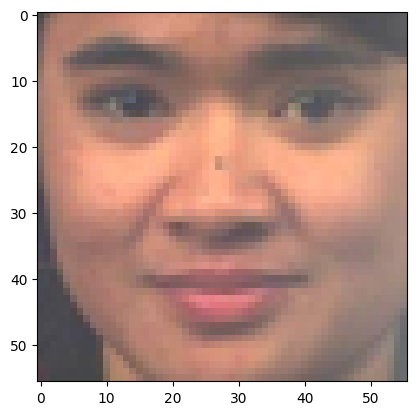

In [8]:
import matplotlib.pyplot as plt

ds = FacesDataset(im_path="/data/michele/IST-MDB/bonafide")

im = ds[269]

print(im.shape)

lens = []
for i in ds.identities:
    lens.append(len(ds.identities[i]))

print(set(lens))  # i only have identities with two images (=> i always have both neutral and smile)
plt.imshow(im.transpose(0, 2).transpose(0, 1).numpy())
plt.show()


In [9]:
BATCH_SIZE = 4
NUM_EPOCHS = 40

In [10]:
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_ds, test_ds = torch.utils.data.random_split(ds, [train_size, test_size])

In [11]:
print(len(train_ds), len(test_ds)) # ok thats good 

1015 254


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchmetrics.image import StructuralSimilarityIndexMeasure
import torch.optim.lr_scheduler as lr_scheduler

def train(model, dataset):
    
    dataset = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    model.train()
    # Create output directories
    if not os.path.exists("out"):
        os.mkdir("out")
    
    # Specify training parameters
    optimizer = Adam(model.parameters(), lr=0.1)
    # learning rate scheduler to decrease it gradually ...
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

    ssim = StructuralSimilarityIndexMeasure(data_range=1).to(device)
    mae = nn.L1Loss()
    
    # Run training
    for epoch_idx in range(NUM_EPOCHS):
        losses = []
        if device.type == 'cuda':
             torch.cuda.empty_cache()
        lastimg = None
        lastReco = None

        for image in tqdm(dataset):

            optimizer.zero_grad()
            image = image.float().to(device)

            reconstructed = model(image)


            loss = 1 - ssim(image, reconstructed) # + mae(image, reconstructed)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            lastimg = image
            lastReco = reconstructed

        scheduler.step()

        fig, axs = plt.subplots(1, 2)
        

        axs[0].imshow(lastimg[0].detach().cpu().transpose(0, 2).transpose(0, 1).numpy())
        axs[0].set_title('image')
        axs[1].imshow(lastReco[0].detach().cpu().transpose(0, 2).transpose(0, 1).numpy())
        axs[1].set_title('reconstructed')
        plt.show()
        print('Finished epoch:{} | Loss : {:.4f}'.format(
            epoch_idx + 1,
            np.mean(losses),
        ))
        torch.save(model.state_dict(), os.path.join("out_ae",
                                                    "ae_{}.pth".format(epoch_idx)))
    
    print('Done Training ...')

Using device: cuda


In [14]:
model = unet(3, num_layers=3,skip_connections=False).to(device)

100%|██████████| 254/254 [02:16<00:00,  1.86it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-36.58417..0.9736984].


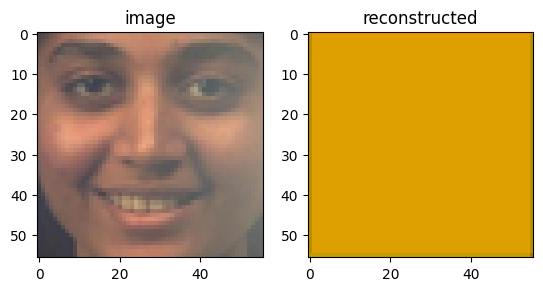

Finished epoch:1 | Loss : 0.8293


100%|██████████| 254/254 [02:16<00:00,  1.86it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-60.450684..0.77942646].


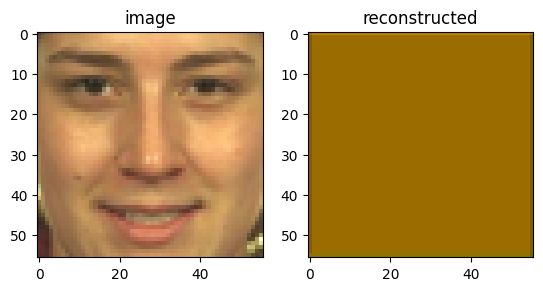

Finished epoch:2 | Loss : 0.8119


 88%|████████▊ | 224/254 [02:00<00:16,  1.85it/s]


KeyboardInterrupt: 

In [15]:
train(model, train_ds)